In [1]:
fundo = 'xpml11'
cnpj = '28.757.546/0001-00'
anos = ['2022' , '2023' , '2024']

In [2]:
import requests
import zipfile

def baixar_e_extrair_zip(url, caminho_destino = '/content'):
  """
  Baixa um arquivo ZIP de uma URL e extrai os arquivos para um caminho de destino.

  Args:
      url: A URL do arquivo ZIP.
      caminho_destino: O caminho para o qual os arquivos devem ser extraídos.
  """
  resposta = requests.get(url, stream=True)
  resposta.raise_for_status()  # Lança uma exceção se houver um erro na resposta

  with open("arquivo.zip", "wb") as arquivo_zip:
    for pedaço in resposta.iter_content(chunk_size=1024):
      arquivo_zip.write(pedaço)

  with zipfile.ZipFile("arquivo.zip", 'r') as zip_ref:
    zip_ref.extractall(caminho_destino)


In [3]:
for ano in anos:
  url = f'https://dados.cvm.gov.br/dados/FII/DOC/INF_MENSAL/DADOS/inf_mensal_fii_{ano}.zip'
  baixar_e_extrair_zip(url)

In [4]:
import pandas as pd

def ler_arquivos_fii(arquivos, colunas):
  """
  Lê múltiplos arquivos CSV com informações de FIIs em um único DataFrame.

  Args:
      arquivos: Uma lista de caminhos de arquivos CSV.
      colunas: Uma lista de nomes de colunas a serem lidas.

  Returns:
      Um DataFrame do Pandas com os dados combinados.
  """

  dfs = []  # Lista para armazenar os DataFrames de cada arquivo
  for arquivo in arquivos:
    df = pd.read_csv(arquivo, sep=';', usecols=colunas, parse_dates=['Data_Referencia'],
                     encoding='latin-1')
    df['Valor_Patrimonial_Cotas'] = df['Valor_Patrimonial_Cotas'].astype(float)
    dfs.append(df)

  df_combinado = pd.concat(dfs, ignore_index=True)
  return df_combinado

In [7]:
arquivos = [f'/content/inf_mensal_fii_complemento_{ano}.csv'  for ano in anos]
colunas = ['CNPJ_Fundo', 'Data_Referencia', 'Valor_Patrimonial_Cotas']
df_fii = ler_arquivos_fii(arquivos, colunas)

In [8]:
dados = df_fii[df_fii['CNPJ_Fundo'] == cnpj][['Data_Referencia','Valor_Patrimonial_Cotas']].copy()
dados['Data_Referencia'] = pd.to_datetime(dados['Data_Referencia']).dt.date

dados.head(3)

,Data_Referencia,Valor_Patrimonial_Cotas
4044,2022-01-01,101.755447
4045,2022-02-01,100.530305
4046,2022-03-01,104.142238


In [19]:
import yfinance as yf
dados_yf = yf.download(fundo+'.SA')[['Adj Close']]

[*********************100%%**********************]  1 of 1 completed


In [54]:
from datetime import datetime

def data_mais_proxima(data_alvo, lista_datas):
  """
  Args:
      data_alvo: A data alvo para comparação.
      lista_datas: A lista de datas para procurar.

  Returns:
      A data em lista_datas mais próxima de data_alvo.
  """
  menor_diferenca = None
  data_mais_proxima = None
  for data in lista_datas:
    diferenca = abs(data_alvo - data.date())
    if menor_diferenca is None or diferenca < menor_diferenca:
      menor_diferenca = diferenca
      data_mais_proxima = data

  return data_mais_proxima

In [70]:
'''
  As datas de referência podemnao ter tido pregão
  Nesse caso, pego o valor do papel na data mais proxima
'''
preco = []
for dia in dados['Data_Referencia'].values:
  data_cota = data_mais_proxima(dia, dados_yf.index).date()
  preco.append(dados_yf.loc[data_cota.strftime('%Y-%m-%d')]['Adj Close'])
dados['preco'] = preco

In [68]:
dados['preco'] = preco

In [71]:
dados.head(3)

,Data_Referencia,Valor_Patrimonial_Cotas,preco
4044,2022-01-01,101.755447,80.461403
4045,2022-02-01,100.530305,79.344658
4046,2022-03-01,104.142238,73.623413


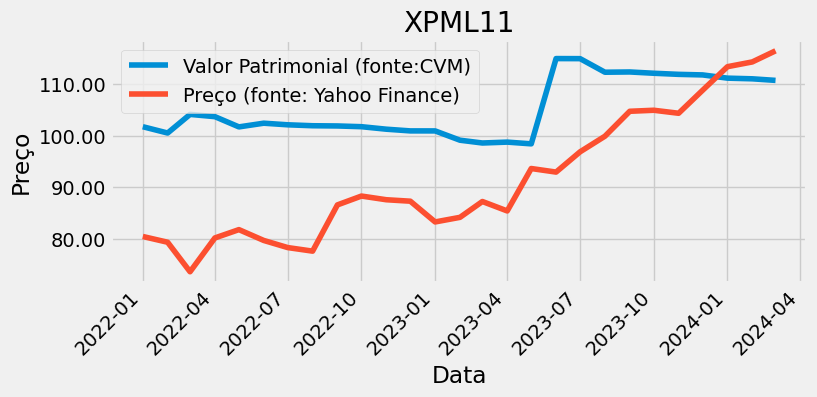

In [76]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

def plotar_dados_fii(dados, fundo):
  """
  Plota os dados de 'Valor_Patrimonial_Cotas' e 'preco' de um fundo imobiliário.

  Args:
      dados: DataFrame com colunas 'Data_Referencia', 'Valor_Patrimonial_Cotas' e 'preco'.
      fundo: Nome do fundo imobiliário (string) para o título do gráfico.
  """

  plt.figure(figsize=(8, 3))  # Ajustar o tamanho da figura, se necessário

  plt.plot(dados['Data_Referencia'], dados['Valor_Patrimonial_Cotas'], label='Valor Patrimonial (fonte:CVM)')
  plt.plot(dados['Data_Referencia'], dados['preco'], label='Preço (fonte: Yahoo Finance)')

  plt.xlabel('Data')
  plt.ylabel('Preço')
  plt.title(fundo.upper())

  plt.xticks(rotation=45, ha='right')  # Inclinar os labels do eixo x
  plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))  # Duas casas decimais no eixo y


  plt.grid(True)
  plt.legend()
  plt.show()

# Exemplo de uso (assumindo que você já tem o DataFrame 'dados')
plotar_dados_fii(dados, fundo)